In [313]:
'''
Author : Apoorva Saxena
Email  : apoorvasaxena207@gmail.com 
Desc   : Time Series Forcasting of Flow Rate in Gas Wells in order to prevent liquid loading
Summary: This program performs a multivariate (2 variable - Flow Rate and Casing Pressure) 
         time series forcasting using LSTM model. The LSTM model learns the dependncy
         of two variables in the sequence and makes future predictions
'''
import os
import time
import warnings
import sys
import time
import numpy as np
import pandas as pd
import traces
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.regularizers import l1l2
from prettytable import PrettyTable
from datetime import datetime
from datetime import timedelta
from scipy.stats import pearsonr
from scipy.signal import lfilter
from scipy import signal
from statsmodels.nonparametric.smoothers_lowess import lowess
%matplotlib inline

In [167]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

In [368]:
def load_data(filename, features, data_range = None):
    '''
    Loading data from csv file. The complete dataset is divided into 
    11 decline curves which will be used in training and testing phases
    '''
    df = pd.read_csv(filename)
    df.Time = df['Time'].apply(lambda x : pd.to_datetime(x, unit='s'))
    df = df[features]
    df_list = []
    if data_range:
        for rng in data_range:
            temp_df = df[rng[0] : rng[1]]
            temp_df = temp_df[temp_df.FlowRate < 1500]
            df_list.append(temp_df)
    else:
        df_list.append(df)
    return df_list


def regularize_time_intervals(df, interval, feature, Y, M, D, h, m, s):
    '''
    Coverting irregular time intervals to regular time intervals using traces
    https://traces.readthedocs.io/
    ''' 
    time = map(lambda x: x.to_datetime(), pd.to_datetime(df.Time))
    f = list(df[feature])
    ts = traces.TimeSeries(data=zip(time, f))
    regularized_f = ts.moving_average(
        start=datetime(Y, M, D, h, m, s),
        sampling_period=interval,
        placement='left',
    )
    return zip(*regularized_f)


def process_data(seq_len, data_type, time, *data):
    '''
    Convert the data for supervised learning (to feed LSTM model)
    The data is formatted for superised learning into X tensor and Y vector
    '''
    sequence_length = seq_len + 1
    result = []
    time_list = []
    data = zip(*data)
    for index in range(len(data) - sequence_length + 1):
        result.append(data[index : index + sequence_length])
        time_list.append(time[index : index + sequence_length])
    result = np.array(result)
    time_list = np.array(time_list)
    
    if data_type == 'train':
        row = int(1. * result.shape[0])
    else:
        row = int(0. * result.shape[0])
    train = result[:int(row), : ]
    #np.random.shuffle(train)
    x_train = train[:,:-1]
    y_train = train[:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]
    time_train = time_list[:int(row), :-1]
    time_test = time_list[int(row):, :-1]
    
    
    print x_train.shape
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))
    
    return x_train, y_train, x_test, y_test, result, time_train, time_test 

    
    
def normalize_data(data, min_val , max_val):
    '''
    Normalize data (x) using the formula:
    
                        x - min
     x_normalized =  ------------
                       max - min
                       
    where min the minimum of all x and max is maximum of all x
    '''
    normalized_data = map(lambda x : (x - min_val)/(max_val - min_val), data)
    return normalized_data

def denormalize_data(data, min_val_fr, max_val_fr, min_val_cp, max_val_cp):
    '''
    Normalize data (x) using the formula:
   
    x_unnormalized = x * (max - min) + min
                       
    where min the minimum of all x and max is maximum of all x
    '''
    unnormalized_data = map(lambda x : [x[0]*(max_val_fr - min_val_fr) + min_val_fr, x[1]*(max_val_cp - min_val_cp) + min_val_cp], data)
    return unnormalized_data

def build_model(layers):
    '''
    Builds the LSTM model with Keras:
    Model - Input, Hidden Layer 1, Hidden Layer 2, Hidden Layer 3, Output
    Cost function - Mean Squared Error
    Optimizer - Adam optimizer : https://arxiv.org/abs/1412.6980v8
    '''
    model = Sequential()
    
    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True,
        ))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences=True,
   
        ))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[3],
        return_sequences=False,

        ))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        output_dim=layers[4]))
    
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
    return model

def predict_sequences_multiple(model, data, window_size, prediction_len):
    '''
    Returns future forcast for the specified prediction length
    '''
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        #print i*prediction_len
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0:2])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis = 0)
        prediction_seqs.append(predicted)
    return prediction_seqs 

def fr_select(x):
    '''
    Separating FlowRate from FlowRate
    '''
    return [list(item)[0] for item in x]

def get_time_points(time_data, prediction_len, time_step):
    '''
    Get the corresponding time points for the predicted Flow Rate values
    given the time step (600) and prediction length
    '''
    time_points = []
    for i in range(int(len(time_data)/prediction_len)):
        last_time_point = time_data[i*prediction_len][-1]
        future_time_points = []
        for j in range(prediction_len):
            future_time_point = last_time_point + timedelta(seconds = 600)
            future_time_points.append(future_time_point)
            last_time_point = future_time_points[-1]
        time_points.append(future_time_points)
    return time_points
    

In [356]:
data_range = [(66,867), 
              (985, 3017), 
              (3069, 3813), 
              (3872, 5641), 
              (5651, 6018), 
              (6020, 8215),
              (8216, 10906),
              (10908, 14435),
              (14468, 17000),
              (17066, 20532),
              (20684, 21643)
             ]
df_list = load_data('data.csv', ['Time', 'CasingPressure','FlowRate'], data_range)
for df in df_list:
    print df.head()

                  Time  CasingPressure  FlowRate
66 2015-07-25 14:27:41         490.338   925.841
67 2015-07-25 14:30:40         489.880   882.678
68 2015-07-25 14:33:42         489.605   835.654
69 2015-07-25 14:36:39         489.422   891.476
70 2015-07-25 14:39:37         489.147   843.991
                   Time  CasingPressure  FlowRate
985 2015-07-27 16:57:37         386.665  1183.170
986 2015-07-27 17:00:42         386.574  1163.370
987 2015-07-27 17:03:41         386.299  1104.777
988 2015-07-27 17:06:40         385.841  1129.398
989 2015-07-27 17:09:39         386.574  1144.112
                    Time  CasingPressure  FlowRate
3069 2015-08-01 13:30:41         401.227   876.778
3070 2015-08-01 13:33:40         401.594   849.514
3071 2015-08-01 13:36:39         401.777   748.584
3072 2015-08-01 13:39:38         402.051   822.124
3073 2015-08-01 13:42:37         401.777   772.918
                    Time  CasingPressure  FlowRate
3872 2015-08-03 11:33:41         454.254  1190.64

In [357]:
st_list = [[df.iloc[0].Time.year, df.iloc[0].Time.month, df.iloc[0].Time.day, df.iloc[0].Time.hour, df.iloc[0].Time.minute, df.iloc[0].Time.second] for df in df_list]

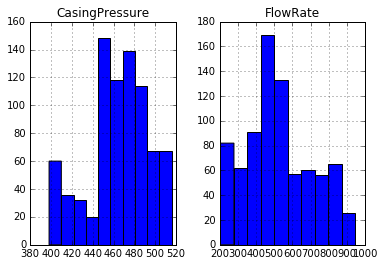

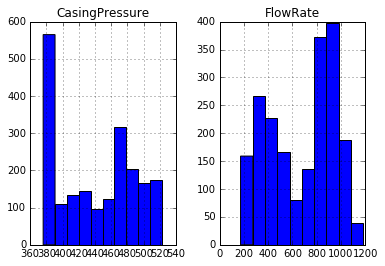

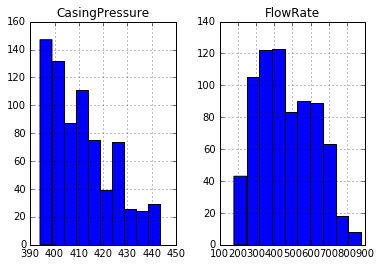

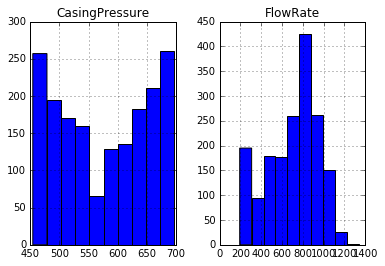

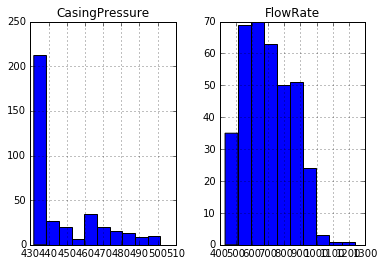

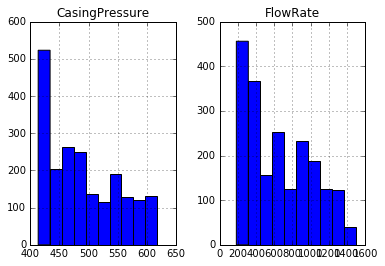

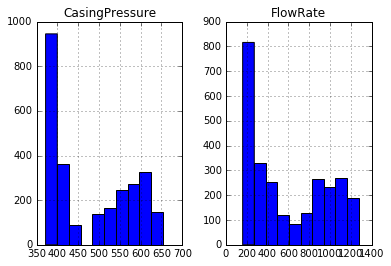

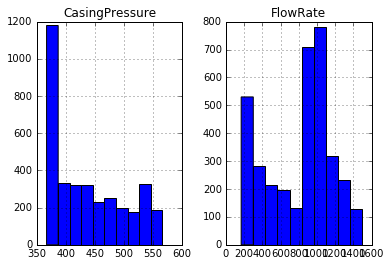

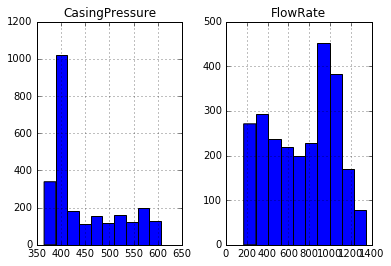

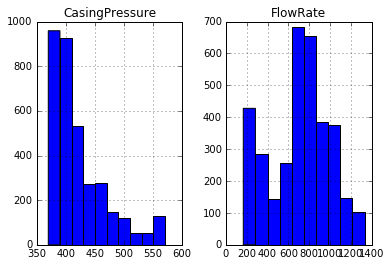

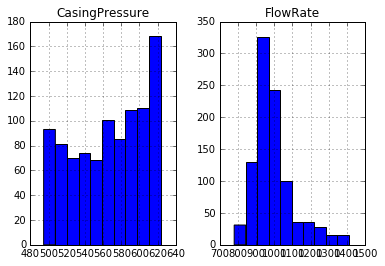

In [358]:
'''
Plotting histograms to learn the distribution of the 
two variables. I was plotting these in hope to learn
the distribution so that I can establish a correlation 
between these variables. Do not see any useful results
'''
for df in df_list:
    df.hist()

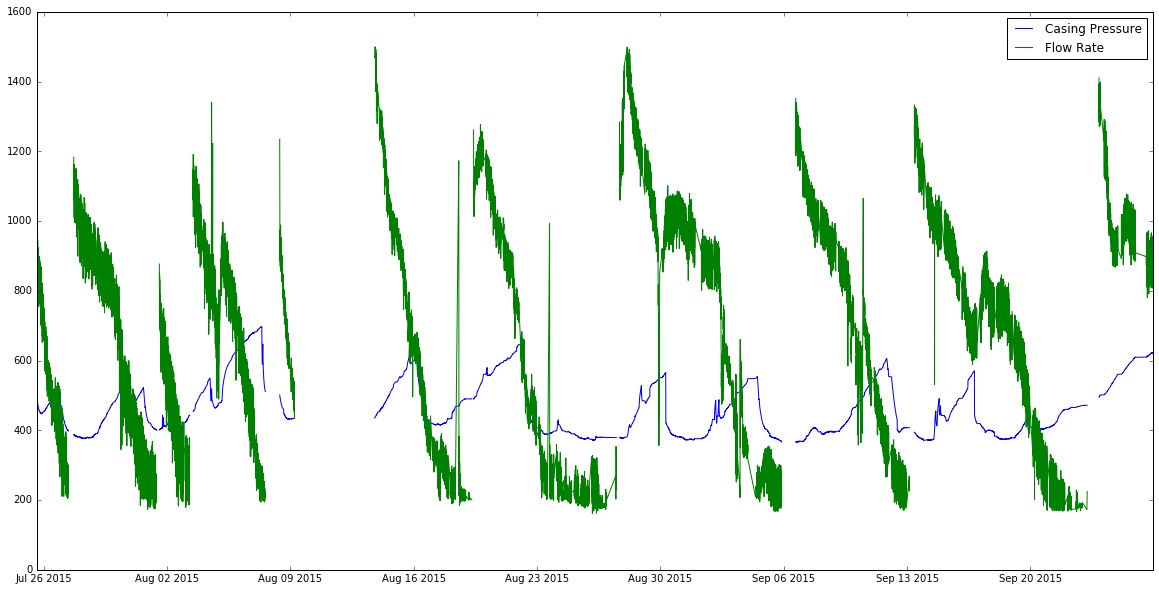

In [359]:
'''
Actual Data
'''
fig, ax = plt.subplots(figsize=(20, 10), dpi=100, facecolor='w', edgecolor='k')
for i, df in enumerate(df_list):
    ax.plot(df.Time, df.CasingPressure, label='Casing Pressure' if i == 0 else "", color = 'b')
    ax.plot(df.Time, df.FlowRate, label = 'Flow Rate' if i == 0 else "", color = 'g')
plt.legend()

In [360]:
'''
Regularizing time interval
'''
time_list = []
fr_list = []
cp_list = []
for df,st in zip(df_list,st_list):
    time, fr = regularize_time_intervals(df, 600, 'FlowRate',*st)
    time, cp = regularize_time_intervals(df, 600, 'CasingPressure',*st)
    time_list.append(time)
    fr_list.append(fr)
    cp_list.append(cp)

In [361]:
'''
Apply noise filters - forward - backward filter
'''
b, a = signal.butter(1, 0.05)
for i in range(len(time_list)):
    fr_list[i] = signal.filtfilt(b,a,fr_list[i])
for i in range(len(time_list)):
    cp_list[i] = signal.filtfilt(b,a,cp_list[i])

In [362]:
df_transformed_list = []
for time, fr, cp in zip(time_list, fr_list, cp_list):
    df_transformed_list.append(pd.DataFrame({'Time': time, 'FlowRate': fr, 'CasingPressure' : cp}, columns=['Time', 'FlowRate', 'CasingPressure']))

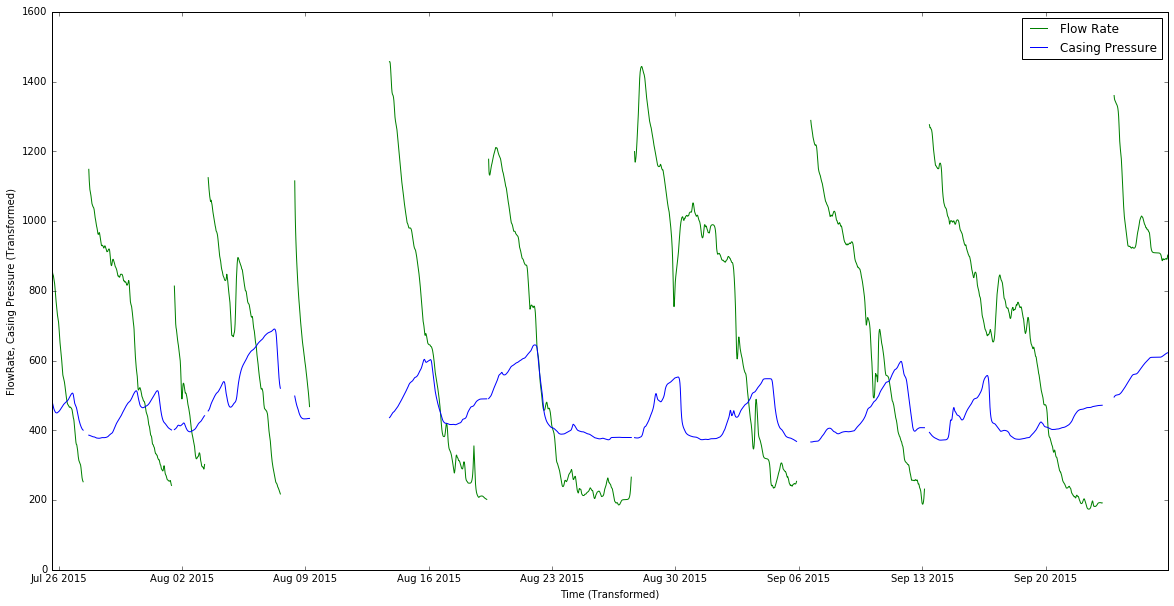

In [363]:
'''
Transformed Data after regularizing time interval and noise filtering
'''
fig, ax = plt.subplots(figsize=(20, 10), dpi=100, facecolor='w', edgecolor='k')
for i, df_transformed in enumerate(df_transformed_list):
    ax.plot(df_transformed.Time, df_transformed.FlowRate, color = 'g', label = 'Flow Rate' if i == 0 else "", )
    ax.plot(df_transformed.Time, df_transformed.CasingPressure, color = 'b', label = 'Casing Pressure' if i == 0 else "", )
ax.set_xlabel('Time (Transformed)')
ax.set_ylabel('FlowRate, Casing Pressure (Transformed)')
plt.legend()

In [364]:
raw_values_fr_list = []
raw_values_cp_list = []
for df_transformed in df_transformed_list:
    raw_values_fr_list.append(list(df_transformed['FlowRate']))
    raw_values_cp_list.append(list(df_transformed['CasingPressure']))

In [365]:
#global_min_fr = min([min(each) for each in raw_values_fr_list])
#global_max_fr = max(max(each) for each in raw_values_fr_list)
min_val_fr_list = []
max_val_fr_list = []
normalized_data_fr_list = []
for raw_values_fr in raw_values_fr_list:
    min_val_fr = min(raw_values_fr)
    max_val_fr = max(raw_values_fr)
    #min_val_fr = global_min_fr
    #max_val_fr = global_max_fr
    normalized_data_fr_list.append(normalize_data(raw_values_fr, min_val_fr, max_val_fr))
    min_val_fr_list.append(min_val_fr)
    max_val_fr_list.append(max_val_fr)

In [369]:
#global_min_cp = min([min(each) for each in raw_values_cp_list])
#global_max_cp = max(max(each) for each in raw_values_cp_list)
min_val_cp_list = []
max_val_cp_list = []
normalized_data_cp_list = []
for raw_values_cp in raw_values_cp_list:
    min_val_cp = min(raw_values_cp)
    max_val_cp = max(raw_values_cp)
    #min_val_cp = global_min_cp
    #max_val_cp = global_max_cp
    normalized_data_cp_list.append(normalize_data(raw_values_cp, min_val_cp, max_val_cp))
    min_val_cp_list.append(min_val_cp)
    max_val_cp_list.append(max_val_cp)

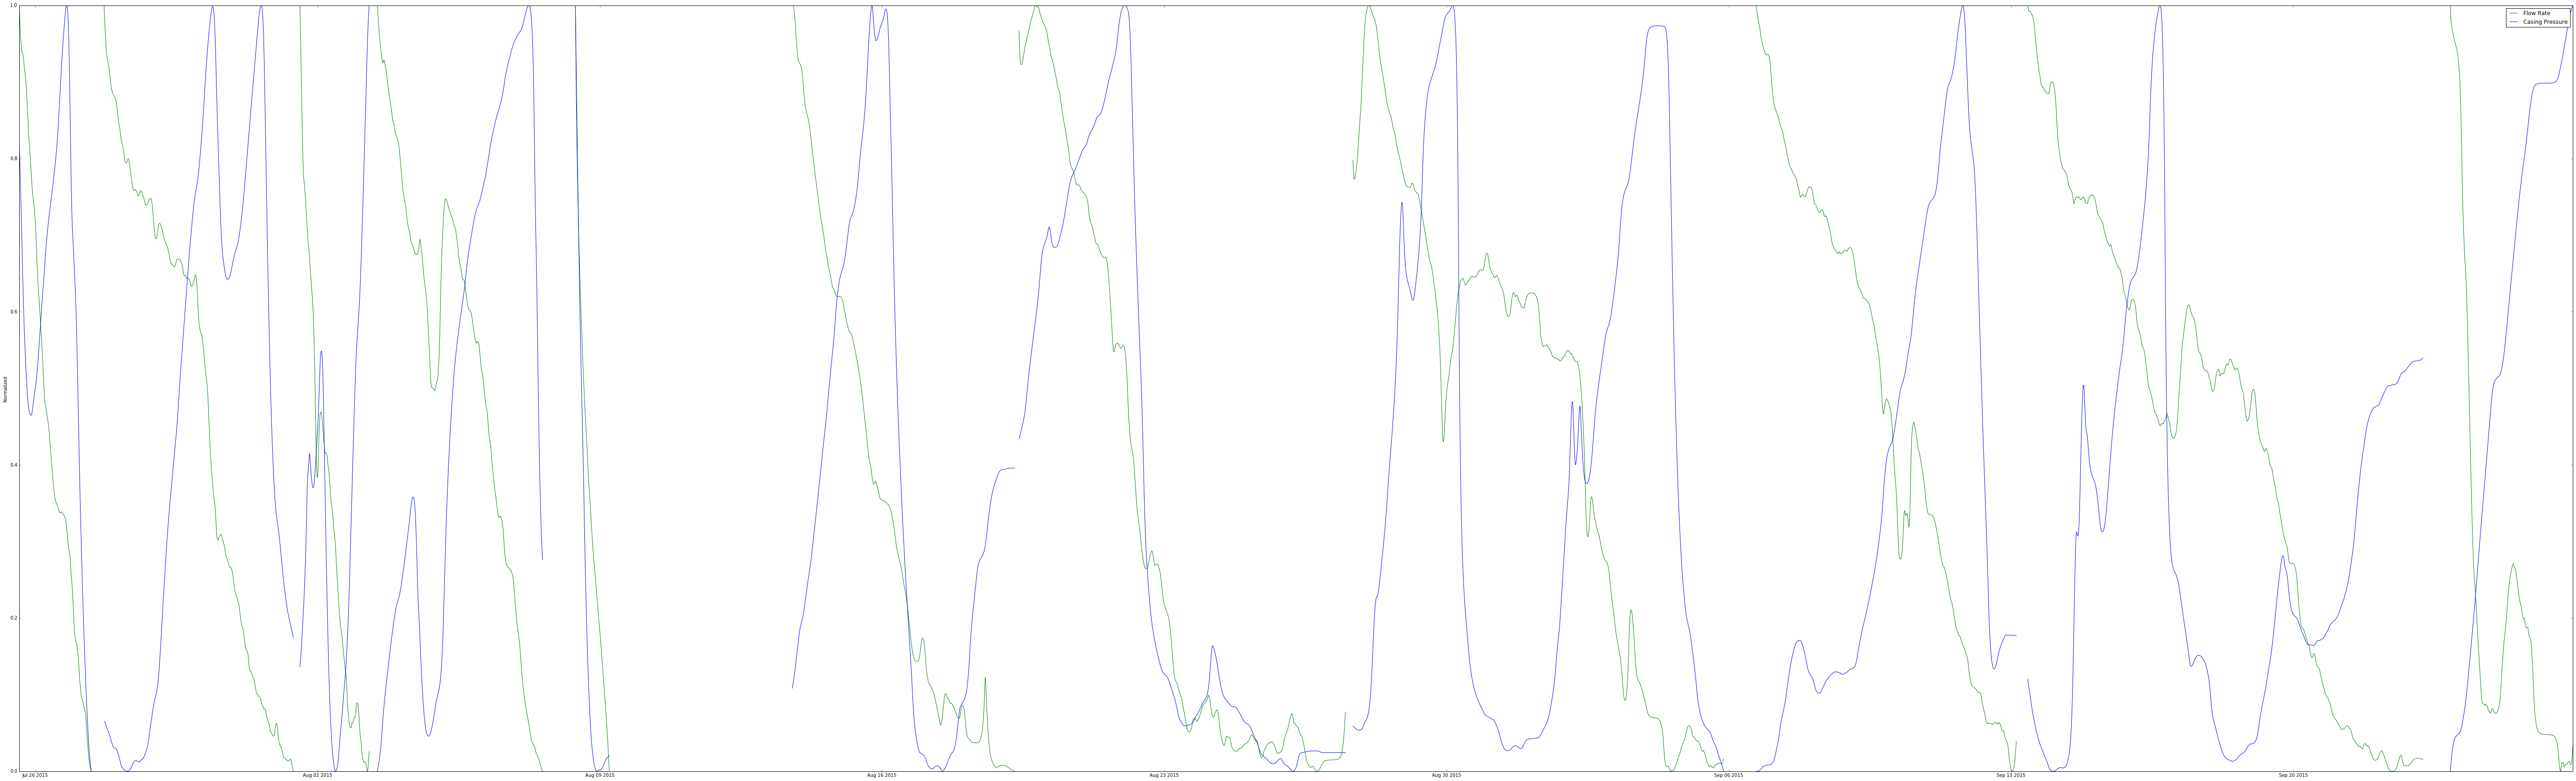

In [370]:
'''
Normailzed data
'''
fig, ax = plt.subplots(figsize=(100, 30), dpi=100, facecolor='w', edgecolor='k')
for i, normalized_data_fr, normalized_data_cp, time  in zip(range(len(normalized_data_fr_list)), normalized_data_fr_list, normalized_data_cp_list, time_list):
    plt.plot(time, normalized_data_fr, label='Flow Rate' if i == 0 else "", color = 'g')
    plt.plot(time, normalized_data_cp, label='Casing Pressure' if i == 0 else "", color='b')
ax.set_ylabel('Normalized')
plt.legend()

In [371]:
'''
Generating training and testing data
'''
X_train_list = []
time_train_list = []
y_train_list =[]
X_test_list = []
time_test_list = []
y_test_list = []
result_list = []
train_idx = [0,1,2,3,5,6,7,8]
test_idx = [4,9,10]
N = 11

for i, normalized_data_fr, normalized_data_cp, time in zip(range(N),normalized_data_fr_list, normalized_data_cp_list, time_list):
    if i in train_idx:
        X_train, y_train, X_test, y_test, result, time_train, time_test = process_data(100, 'train', time, normalized_data_fr, normalized_data_cp)
    else:
        X_train, y_train, X_test, y_test, result, time_test, time_test = process_data(100, 'test', time, normalized_data_fr, normalized_data_cp)
    
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    result_list.append(result)
    time_train_list.append(time_train)
    time_test_list.append(time_test)

(158, 100, 2)
(577, 100, 2)
(148, 100, 2)
(491, 100, 2)
(0, 100, 2)
(696, 100, 2)
(1067, 100, 2)
(1225, 100, 2)
(830, 100, 2)
(0, 100, 2)
(0, 100, 2)


In [372]:
X_train = reduce(lambda x, y : np.concatenate((x,y) , axis = 0), X_train_list)
y_train = reduce(lambda x, y : np.concatenate((x,y) , axis = 0), y_train_list)
X_test = reduce(lambda x, y : np.concatenate((x,y) , axis = 0), X_test_list)
y_test = reduce(lambda x, y : np.concatenate((x,y) , axis = 0), y_test_list)
result = reduce(lambda x, y : np.concatenate((x,y) , axis = 0), result_list)

In [373]:
'''
Compiling LSTM model with given neuron in corresponsing layers
and input weight regularizer
'''
model = build_model([2,100,500,200,2])

In [374]:
seq_len = 100
epochs = 5

In [377]:
'''
Training the model
'''
model.fit(
    X_train,
    y_train,
    batch_size=14,
    nb_epoch=epochs,
    verbose=2)

Epoch 1/5
184s - loss: 0.0014 - acc: 0.9624
Epoch 2/5
193s - loss: 0.0011 - acc: 0.9684
Epoch 3/5
709s - loss: 0.0011 - acc: 0.9717
Epoch 4/5
178s - loss: 0.0011 - acc: 0.9694
Epoch 5/5
230s - loss: 9.9492e-04 - acc: 0.9705


In [378]:
'''
Making predictions on training and testing data

'''
predictions_test_list = []
predictions_train_list = []
for i, x_test, x_train in zip(range(N), X_test_list, X_train_list):
    predictions_test_list.append(predict_sequences_multiple(model, x_test, seq_len, 50))
    predictions_train_list.append(predict_sequences_multiple(model, x_train, seq_len, 50))

In [379]:
'''
De-normalizing predicted data
'''
predictions_test_unnormalize_list = []
predictions_train_unnormalize_list = []
y_test_unnormalize_list = []
y_train_unnormalize_list = []
for i, predictions_test, predictions_train in zip(range(N), predictions_test_list, predictions_train_list):
    predictions_test_unnormalize_list.append(map(lambda x : denormalize_data(x, min_val_fr_list[i], max_val_fr_list[i], min_val_cp_list[i], max_val_cp_list[i]), predictions_test))
    predictions_train_unnormalize_list.append(map(lambda x : denormalize_data(x, min_val_fr_list[i], max_val_fr_list[i], min_val_cp_list[i], max_val_cp_list[i]), predictions_train))
for i, y_test, y_train in zip(range(N), y_test_list, y_train_list):
    y_test_unnormalize_list.append(denormalize_data(y_test, min_val_fr_list[i], max_val_fr_list[i], min_val_cp_list[i], max_val_cp_list[i]))
    y_train_unnormalize_list.append(denormalize_data(y_train, min_val_fr_list[i], max_val_fr_list[i], min_val_cp_list[i], max_val_cp_list[i]))

In [380]:
'''
Getting the flowrates from predicitions
'''
predictions_test_unnormalize_list_fr = []
predictions_train_unnormalize_list_fr = []
y_test_unnormalize_list_fr = []
y_train_unnormalize_list_fr = []
for i in range(N):
    predictions_test_unnormalize_list_fr.append(map(lambda x : fr_select(x), predictions_test_unnormalize_list[i]))
    predictions_train_unnormalize_list_fr.append(map(lambda x : fr_select(x), predictions_train_unnormalize_list[i]))
    y_test_unnormalize_list_fr.append(fr_select(y_test_unnormalize_list[i]))
    y_train_unnormalize_list_fr.append(fr_select(y_train_unnormalize_list[i]))

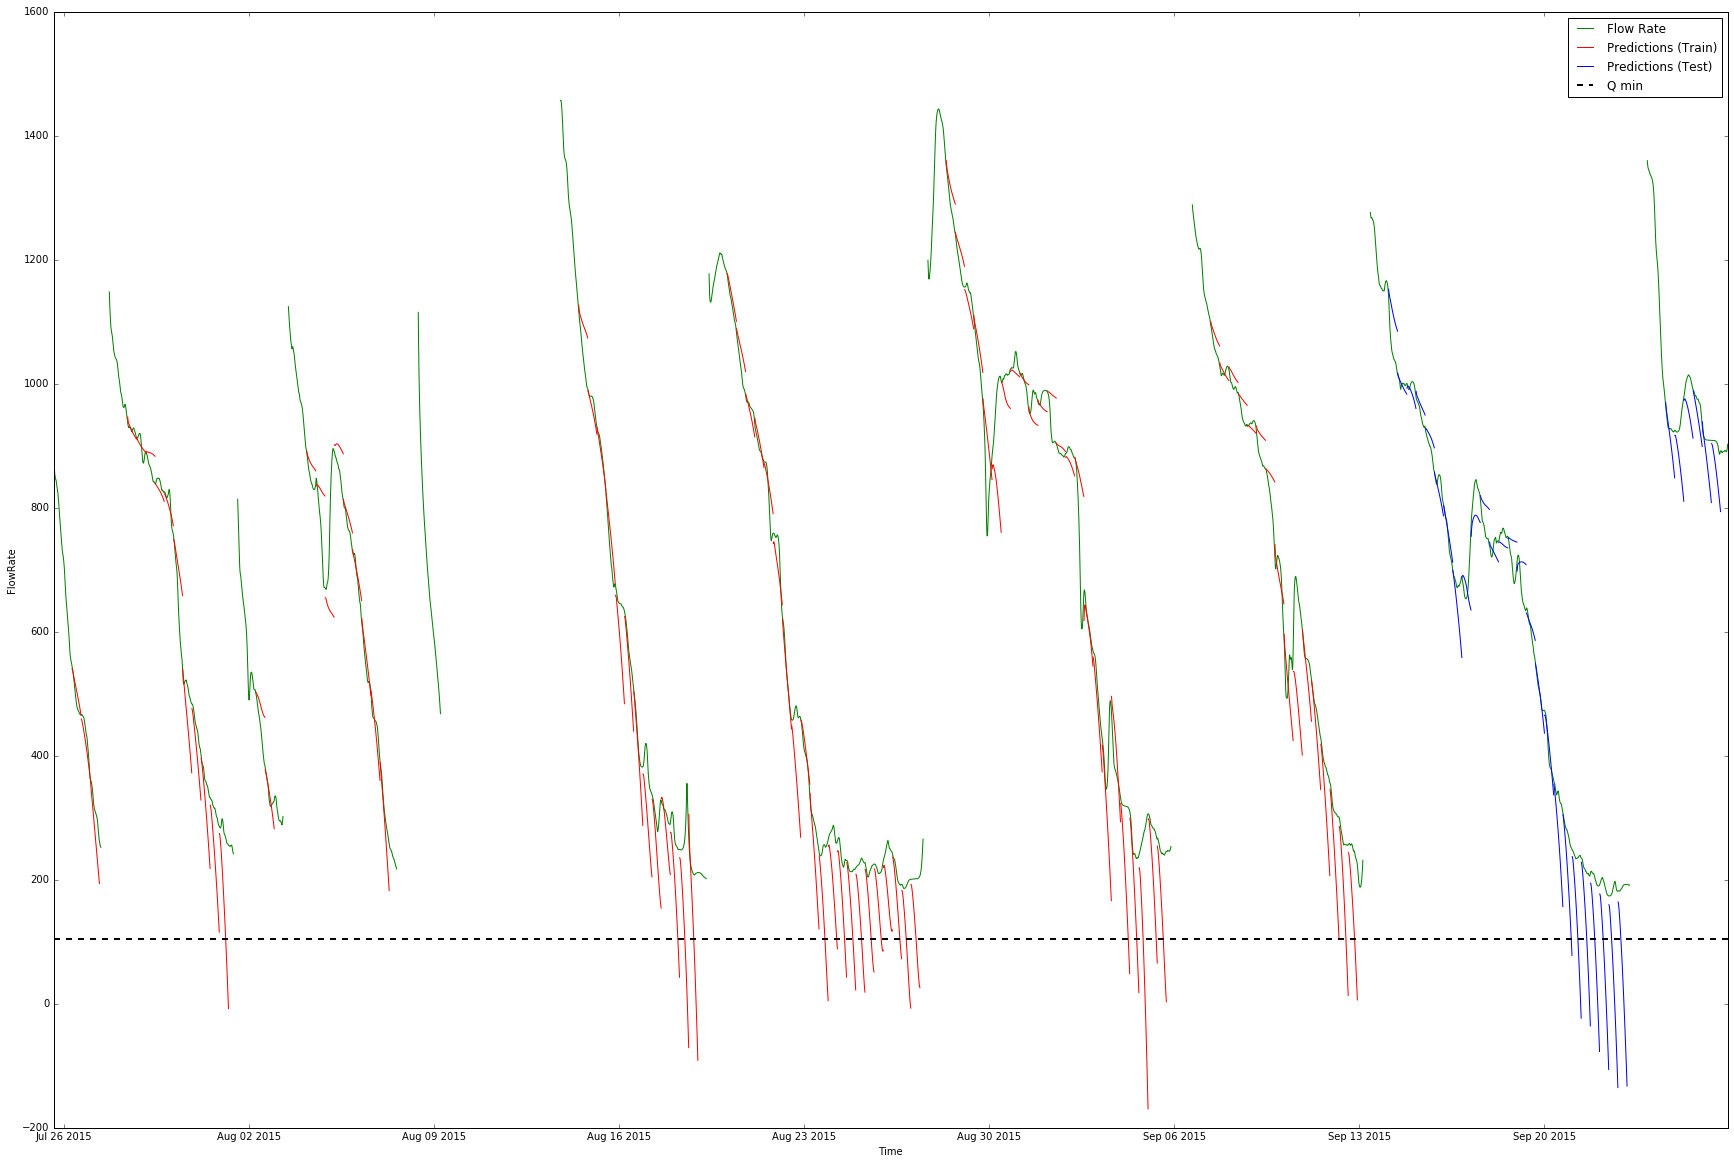

In [381]:
'''
Final results
Read legends for more info
'''
fig, ax = plt.subplots(figsize=(30, 20), dpi=100, facecolor='w', edgecolor='k')
train_legend, test_legend = False, False
for i, df_transformed in enumerate(df_transformed_list):
    ax.plot(time_list[i], df_transformed.FlowRate, color = 'g', label = 'Flow Rate' if i == 0 else "",)
    if i in train_idx:
        future_time_points = get_time_points(time_train_list[i], 50, 600)
        predictions = predictions_train_unnormalize_list_fr[i]
        color = 'red'
        label = 'Predictions (Train)'
        
    else:
        future_time_points = get_time_points(time_test_list[i], 50, 600)
        predictions = predictions_test_unnormalize_list_fr[i]
        color = 'blue'
        label = 'Predictions (Test)'
        
    for j, data, time in zip(range(len(predictions)), predictions, future_time_points):
        if label == 'Predictions (Train)' and not train_legend:
            plt.plot(time, data, label = label, color = color)
            train_legend = True
        elif label == 'Predictions (Test)' and not test_legend:
            plt.plot(time, data, label = label, color = color)
            test_legend = True
        else:
            plt.plot(time, data, label = "", color = color)
ax.set_xlabel('Time')
ax.set_ylabel('FlowRate')
plt.axhline(y=105, color = 'black', label = 'Q min', linestyle='dashed', linewidth=2)
plt.legend()